## TM500 LOG分析脚本
---
**环境**：
- Python 3.5+
- pandas 0.18.1
- matlibplot 2.0.0
- seaborn 0.8
- numpy 1.11.3+mkl

**功能**
- 统计Throughput/UE number/MCS/BLER/CQI等信息

**限制**
- 目前只支持LMF TMA生成的log，不支持其他如NB-IOT log

**历史**
- 0.01: 2017/07/27
- 0.02: 2017/07/28, 修改bug，增加l1dlstats/l1ulstats多cell情况处理

### 导入相关模块，定义Log文件路径和公共函数

In [1]:
import os
import sys
import glob
import pandas as pd
import matplotlib.pyplot as plt  
import matplotlib.dates as md 
import numpy as np

%matplotlib inline

# TM500 Log所在文件路径
file_path = r"D:\userdata\anliu\Desktop\log\0719\tm500\170719_130759" 

# 切换到TM500 log所在路径
try:
    os.chdir(file_path)
except:
    print("The folder does not existed!")

# 读取文件返回关键字开头行的前一行行号
def csv_prepare(file, key="#State"):
    nrow = 0
    with open(file,"r") as f:
        for line in f:
            nrow = nrow + 1
            if line.startswith(key): 
                return nrow-1

### 处理SYSOVERVIEW和L1CELLWATCH

In [2]:
# 处理SYSOVERVIEW Log
def system_overview_process():
    # 读取Log文件，如果文件不存在返回打印信息
    system_overview = glob.glob("./*SYSOVERVIEW*.csv")
    if system_overview:
        file = system_overview[0]
        print("Start to analyze SYSOVERVIEW log...")
    else:
        print("no system overview info!")
        return    
    
    # 读取数据，跳过行开头为#State之前的无效log行和空白行
    # 如果输入数据列有混合类型，pandas默认要找到可以使所占用空间最小的类型来储存你的数据。
    # low_memory设置为false之后，pandas就不进行寻找，直接采用较大的数据类型来储存。
    df_system_overview = pd.read_csv(file, low_memory=False, skip_blank_lines=True, 
                                     skiprows=csv_prepare(file), na_values=['-'])
    # 打印数据前五行和后五行
#     print(df_system_overview.head())
#     print(df_system_overview.tail())
    
    # Log最后一行和最后一列无效，删除它们
    df_system_overview = df_system_overview.iloc[:-1,:-1] 
    # 删除Time列值是NA的行
    df_system_overview.dropna(axis=0, subset=['Time'], inplace=True) 
    # 根据指定的格式把第一列时间字符串解析为时间元组
    df_system_overview['Time'] = [pd.datetime.strptime(d,"%H:%M:%S:%f") for d in df_system_overview['Time']] 
    time = df_system_overview['Time']
    
    # Active DL/UL UEs数
    ues_active_dl = df_system_overview['Active DL UEs']
    ues_active_ul = df_system_overview['Active UL UEs']
    print("dl active ue num: {:.2f}".format(ues_active_dl.mean()))
    print("ul active ue num: {:.2f}".format(ues_active_ul.mean()))     
    
    # DL/UL-SCH Throughput
    dlsch_tput = df_system_overview['DL-SCH Throughput(kbps)']
    ulsch_tput = df_system_overview['UL-SCH Throughput(kbps)']
    print("dl-sch tput: {:.2f}Mbps".format(dlsch_tput.mean()/1000))
    print("ul-sch tput: {:.2f}Mbps".format(ulsch_tput.mean()/1000))   
    
    # DL/UL per tti的UE数
    dl_tti_num = 17
    ul_tti_num = 17
    ues_per_tti_dl = df_system_overview['Average DL UEs per TTI']
    ues_per_tti_ul = df_system_overview['Average UL UEs per TTI']
    print("ue num per tti for (dl>={0}): {1:.2f}%".format(
          dl_tti_num, ues_per_tti_dl[ues_per_tti_dl>=dl_tti_num].count()/ues_per_tti_dl.count()*100)
         ) 
    print("max ue num per tti for dl: {:.2f}".format(ues_per_tti_dl.max()))
    print("min ue num per tti for dl: {:.2f}".format(ues_per_tti_dl.min()))
    print("mean ue num per tti for dl: {:.2f}".format(ues_per_tti_dl.mean()))    

    print("ue num per tti for (ul>={0}): {1:.2f}%".format(
          ul_tti_num, ues_per_tti_ul[ues_per_tti_ul>=ul_tti_num].count()/ues_per_tti_ul.count()*100)
         )
    print("max ue num per tti for ul: {:.2f}".format(ues_per_tti_ul.max()))
    print("min ue num per tti for ul: {:.2f}".format(ues_per_tti_ul.min()))
    print("mean ue num per tti for ul: {:.2f}".format(ues_per_tti_ul.mean()))

    # 分位数使用方法
#     print("10% ue num per tti for (ul>={:.2f})".format(ues_per_tti_ul.quantile(0.9)))

    # 可视化   
    fig = plt.figure(1,(12,8))
    xfmt = md.DateFormatter('%H:%M:%S')
    
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(time, dlsch_tput, c='b', lw=1.0, ls='-')
    ax1.set_ylabel("Throughput(kbps)")
    ax1.set_ylim(dlsch_tput.min()*0.9,dlsch_tput.max()*1.1+0.01)
    ax1.xaxis.set_major_formatter(xfmt)
    ax1.set_title('DL Throughput')
    
    ax2 = fig.add_subplot(2,1,2, sharex=ax1) 
    ax2.plot(time, ulsch_tput, c='r', lw=1.0, ls='-')
    ax2.set_ylabel("Throughput(kbps)")
    ax2.set_ylim(ulsch_tput.min()*0.9,ulsch_tput.max()*1.1+0.01)    
    ax2.set_title('UL Throughput')    
    
    plt.show()
 
## TODO: 增加对多Cell的处理
def l1cellwatch_process():
    # 读取Log文件，如果文件不存在返回打印信息
    l1cellwatch = glob.glob("./*L1CELLWATCH*.csv")
    if l1cellwatch:
        file = l1cellwatch[0]
        print("Start to analyze L1CELLWATCH log...")
    else:
        print("no l1cellwatch info!")
        return  
    
    # 读取数据，跳过行开头为#State之前的无效log行和空白行
    # 如果输入数据列有混合类型，pandas默认要找到可以使所占用空间最小的类型来储存你的数据。
    # low_memory设置为false之后，pandas就不进行寻找，直接采用较大的数据类型来储存。
    df_l1cellwatch = pd.read_csv(file, low_memory=False, skip_blank_lines=True, 
                                 skiprows=csv_prepare(file), na_values=['-'])

    # Log最后一行和最后一列无效，删除它们
    df_l1cellwatch = df_l1cellwatch.iloc[:-1,:-1] 
    # 删除Time列值是NA的行
    df_l1cellwatch.dropna(axis=0, subset=['Time'], inplace=True) 
    # 根据指定的格式把第一列时间字符串解析为时间元组
    df_l1cellwatch['Time'] = [pd.datetime.strptime(d,"%H:%M:%S:%f") for d in df_l1cellwatch['Time']] 
    time = df_l1cellwatch['Time']
    
    # RSRP和RSRQ
    rsrp = df_l1cellwatch['RSRP(dBm)']
    rsrq = df_l1cellwatch['RSRQ(dB)']
    print("mean rsrp: {:.1f}dBm".format(rsrp.mean()))
    print("mean rsrq: {:.1f}dB".format(rsrq.mean()))    
    
    # 可视化   
    fig = plt.figure(1,(12,4))
    xfmt = md.DateFormatter('%H:%M:%S')
    
    ax1 = fig.add_subplot(111)
    ax1.plot(time, rsrp, c='g', lw=1.0, ls='-', label='RSRP')
    ax1.set_ylabel("RSRP (dBm)")
    ax1.set_ylim(rsrp.min()*0.9,rsrp.max()*1.1+0.01)
    ax1.xaxis.set_major_formatter(xfmt)
    ax1.set_title('RSRP/RSRQ') 
    ax1.legend(loc=2)
    ax2 = ax1.twinx()
    ax2.plot(time, rsrq, c='r', lw=1.0, ls='--', label='RSRQ')
    ax2.set_ylabel("RSRQ (dB)")
    ax2.set_ylim(rsrq.min()*1.1,rsrq.max()*0.9+0.01)
    ax2.xaxis.set_major_formatter(xfmt) 
    ax2.legend(loc=0)
    plt.show()

Start to analyze SYSOVERVIEW log...
dl active ue num: 455.27
ul active ue num: 449.31
dl-sch tput: 9.31Mbps
ul-sch tput: 17.44Mbps
ue num per tti for (dl>=17): 0.00%
max ue num per tti for dl: 14.43
min ue num per tti for dl: 0.06
mean ue num per tti for dl: 7.54
ue num per tti for (ul>=17): 0.00%
max ue num per tti for ul: 14.59
min ue num per tti for ul: 0.00
mean ue num per tti for ul: 7.57


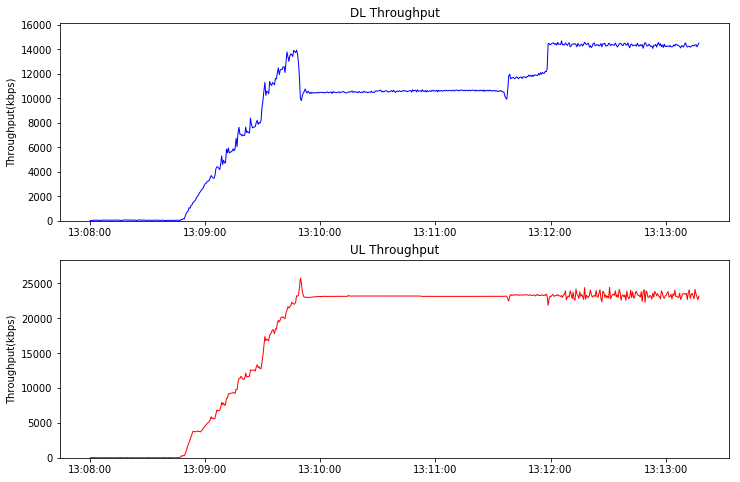

Start to analyze L1CELLWATCH log...
mean rsrp: -61.7dBm
mean rsrq: -5.5dB


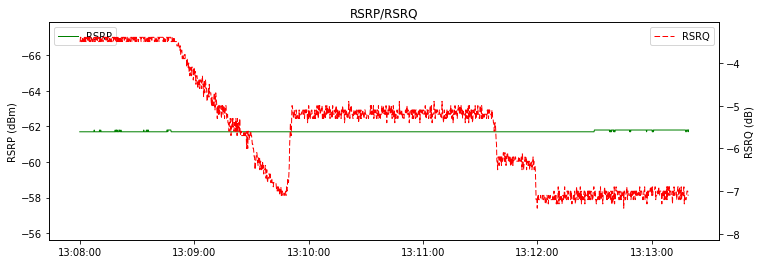

In [3]:
system_overview_process()
l1cellwatch_process()

### 处理L1CellDLOverview和L1CellULOverview

In [4]:
# 处理L1CELLDLOVERVIEW和L1CELLULOVERVIEW Log
def l1celldloverview_process():  
    # 读取Log文件，如果文件不存在返回打印信息
    l1cell_dl_overview = glob.glob("./*L1CELLDLOVERVIEW*.csv")
    if l1cell_dl_overview == []:
        print("no l1celldl overview info!")
        return
   
    print("Start to analyze L1CELLDLOVERVIEW log...")
    
    df_l1cell_dl_overview_list = []
    
    for file in l1cell_dl_overview:
        # 读取数据，跳过行开头为#State之前的无效log行和空白行
        # 如果输入数据列有混合类型，pandas默认要找到可以使所占用空间最小的类型来储存你的数据。
        # low_memory设置为false之后，pandas就不进行寻找，直接采用较大的数据类型来储存。        
        df_l1cell_dl_overview = pd.read_csv(file, low_memory=False, skip_blank_lines=True,
                                            skiprows=csv_prepare(file),na_values=['-']) 


        # Log最后一行和最后一列无效，删除它们
        df_l1cell_dl_overview = df_l1cell_dl_overview.iloc[:-1,:-1] 
        # 删除Time列值是NA的行
        df_l1cell_dl_overview.dropna(axis=0, subset=['Time', 'Cell ID'], inplace=True) 
        df_l1cell_dl_overview.reset_index(inplace=True)        
        # 根据指定的格式把第一列时间字符串解析为时间元组
        df_l1cell_dl_overview['Time'] = [pd.datetime.strptime(d,"%H:%M:%S:%f") for d in df_l1cell_dl_overview['Time']] 

        # cell id, RAT, frequency, DL-SCH Throughput
        cell_id = df_l1cell_dl_overview["Cell ID"][0]
        cell_RAT = df_l1cell_dl_overview["RAT"][0]
        cell_Freq = df_l1cell_dl_overview["Cell Frequency(MHz)"][0]
        cell_dlsch_tput = df_l1cell_dl_overview["Aggregate DL-SCH throughput(kbps)"]
            
        print("Physical Cell ID:",int(cell_id))
        print("CELL RAT: %s" %cell_RAT)
        print("CELL DL Frequency: %s MHz" %cell_Freq)
        print("CELL DL-SCH Throughput: {:.2f}kbps".format(cell_dlsch_tput.mean()))
        
        df_l1cell_dl_overview_list.append(df_l1cell_dl_overview)
    
    # 可视化   
    df_len = len(df_l1cell_dl_overview_list)
    
    # 如果绘制多个subplots，plt.subplots()会返回一个axes数组
    # 如果只有一个subplot, 缺省情况下plt.subplots()会返回axes自身而非一个数组，如果直接使用axes[i]会提示错误
    # 通过设置squeeze=False，这会强制返回 'Rows x Cols'的数组，从而可以使用axes返回每个ax
    fig, axes = plt.subplots(nrows=df_len, ncols=1, figsize=(12,8), squeeze=False)   
    xfmt = md.DateFormatter('%H:%M:%S')
    for i in range(df_len):
        time = df_l1cell_dl_overview_list[i]['Time'] 
        cell_dlsch_tput = df_l1cell_dl_overview_list[i]["Aggregate DL-SCH throughput(kbps)"]
        axes[i,0].plot(time, cell_dlsch_tput, c='b', lw=1.0, ls='-')
        axes[i,0].set_ylabel("DL Throughput(kbps)")
        axes[i,0].set_ylim(cell_dlsch_tput.min()*0.9,cell_dlsch_tput.max()*1.1+0.01)
        axes[i,0].xaxis.set_major_formatter(xfmt)
        axes[i,0].set_title('DL Throughput')   
        
    plt.show()

def l1celluloverview_process():
    # 读取Log文件，如果文件不存在返回打印信息
    l1cell_ul_overview = glob.glob("./*L1CELLULOVERVIEW*.csv")
    if l1cell_ul_overview == []:
        print("no l1cellul overview info!")
        return

    print("Start to analyze L1CELLULOVERVIEW log...")
    
    df_l1cell_ul_overview_list = []
    
    for file in l1cell_ul_overview:
        # 读取数据，跳过行开头为#State之前的无效log行和空白行
        # 如果输入数据列有混合类型，pandas默认要找到可以使所占用空间最小的类型来储存你的数据。
        # low_memory设置为false之后，pandas就不进行寻找，直接采用较大的数据类型来储存。        
        df_l1cell_ul_overview = pd.read_csv(file, low_memory=False, skip_blank_lines=True,
                                            skiprows=csv_prepare(file),na_values=['-']) 


        # Log最后一行和最后一列无效，删除它们
        df_l1cell_ul_overview = df_l1cell_ul_overview.iloc[:-1,:-1] 
        # 删除Time列值是NA的行
        df_l1cell_ul_overview.dropna(axis=0, subset=['Time','Cell ID'], inplace=True) 
        df_l1cell_ul_overview.reset_index(inplace=True)
        # 根据指定的格式把第一列时间字符串解析为时间元组
        df_l1cell_ul_overview['Time'] = [pd.datetime.strptime(d,"%H:%M:%S:%f") for d in df_l1cell_ul_overview['Time']] 

        # cell id, RAT, frequency, DL-SCH Throughput
        cell_id = df_l1cell_ul_overview["Cell ID"][0]
        cell_RAT = df_l1cell_ul_overview["RAT"][0]
        cell_Freq = df_l1cell_ul_overview["Cell Frequency(MHz)"][0]
        cell_ulsch_tput = df_l1cell_ul_overview["Aggregate UL-SCH throughput(kbps)"]
            
        print("Physical Cell ID:",int(cell_id))
        print("CELL RAT: %s" %cell_RAT)
        print("CELL UL Frequency: %s MHz" %cell_Freq)
        print("CELL UL-SCH Throughput: {:.2f}kbps".format(cell_ulsch_tput.mean()))
        
        df_l1cell_ul_overview_list.append(df_l1cell_ul_overview)
    
    # 可视化   
    df_len = len(df_l1cell_ul_overview_list)

    # 如果绘制多个subplots，plt.subplots()会返回一个axes数组
    # 如果只有一个subplot, 缺省情况下plt.subplots()会返回axes自身而非一个数组，如果直接使用axes[i]会提示错误
    # 通过设置squeeze=False，这会强制返回 'Rows x Cols'的数组，从而可以使用axes返回每个ax
    fig, axes = plt.subplots(nrows=df_len, ncols=1, figsize=(12,8), squeeze=False)    
    xfmt = md.DateFormatter('%H:%M:%S')
    for i in range(df_len):
        time = df_l1cell_ul_overview_list[i]['Time'] 
        cell_ulsch_tput = df_l1cell_ul_overview_list[i]["Aggregate UL-SCH throughput(kbps)"]
        axes[i,0].plot(time, cell_ulsch_tput, c='b', lw=1.0, ls='-')
        axes[i,0].set_ylabel("UL Throughput(kbps)")
        axes[i,0].set_ylim(cell_ulsch_tput.min()*0.9,cell_ulsch_tput.max()*1.1+0.01)   
        axes[i,0].xaxis.set_major_formatter(xfmt)    
        axes[i,0].set_title('UL Throughput')   
    
    plt.show()        

Start to analyze L1CELLDLOVERVIEW log...
Physical Cell ID: 185
CELL RAT: FDD
CELL DL Frequency: 940.0 MHz
CELL DL-SCH Throughput: 9308.42kbps


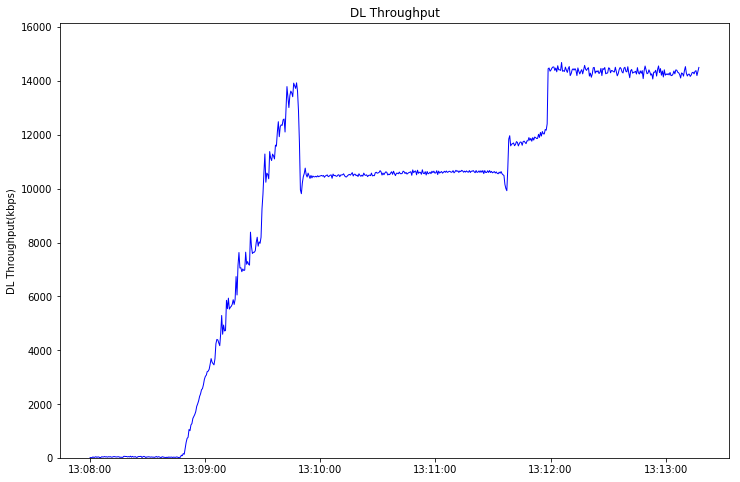

no l1cellul overview info!


In [5]:
l1celldloverview_process()  
l1celluloverview_process()  

### 处理DLSCHRX和ULSCHTX

In [6]:
def dlschrx_process():   
    # 读取Log文件，如果文件不存在返回打印信息    
    dl_sch_rx = glob.glob("./*DLSCHRX*.csv")
    if dl_sch_rx:
        file = dl_sch_rx[0]
    else:
        print("no dl sch info!")
        return
    
    print("Start to analyze DLSCHRX log...")
    
    df_dl_sch_rx = pd.read_csv(file, low_memory=False, skip_blank_lines=True,
                               skiprows=csv_prepare(file), na_values=['-'])

    # 整理数据
    df_dl_sch_rx = df_dl_sch_rx.iloc[:-1,:-1]    
    df_dl_sch_rx.dropna(subset=["Time", "UE ID"], axis=0, inplace=True) 
    df_dl_sch_rx['Time'] = [pd.datetime.strptime(d,"%H:%M:%S:%f") for d in df_dl_sch_rx['Time']] 
    
    #  CW0和CW1的ACK、NACK/调制方式的统计
    ack_nack_tb0_num = df_dl_sch_rx.groupby("ACK/NACK(DL TB: 0)").size()
    ack_nack_tb1_num = df_dl_sch_rx.groupby("ACK/NACK(DL TB: 1)").size()  
    modulation_scheme_tb0 = df_dl_sch_rx.groupby("Modulation Scheme (TB: 0)").size()
    modulation_scheme_tb1 = df_dl_sch_rx.groupby("Modulation Scheme (TB: 1)").size()    

    # 可视化
    fig = plt.figure(figsize=(12,4))
    colors = ['yellowgreen', 'lightskyblue', 'red']
    
    ax1 = fig.add_subplot(121)
    ax1 = ack_nack_tb0_num.plot(kind='pie', colors=colors, autopct='%3.1f%%')
    ax1.axis('equal')
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.set_title('dl_ack_nack_tb0_num')
    
    ax2 = fig.add_subplot(122)
    ax2 = ack_nack_tb0_num.plot(kind='pie', colors=colors, autopct='%3.1f%%')
    ax2.axis('equal')
    ax2.set_xlabel('')
    ax2.set_ylabel('')  
    ax2.set_title('dl_ack_nack_tb1_num')

    plt.show()

    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(121)
    ax1 = modulation_scheme_tb0.plot(kind='pie', colors=colors, autopct='%3.1f%%')
    ax1.axis('equal')
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.set_title('dl_modulation_scheme_tb0')
    
    ax2 = fig.add_subplot(122)
    ax1 = modulation_scheme_tb1.plot(kind='pie', colors=colors, autopct='%3.1f%%')
    ax2.axis('equal')
    ax2.set_xlabel('')
    ax2.set_ylabel('')  
    ax2.set_title('dl_modulation_scheme_tb1')
    
    plt.show()      
    
def ulschtx_process():  
    # 读取Log文件，如果文件不存在返回打印信息   
    ul_sch_tx = glob.glob("./*ULSCHTX*.csv")
    if ul_sch_tx:
        file = ul_sch_tx[0]
    else:
        print("no ul sch info!")
        return

    print("Start to analyze ULSCHRX log...")    
    
    df_ul_sch_tx = pd.read_csv(file, low_memory=False, skip_blank_lines=True, 
                               skiprows=csv_prepare(file), na_values=['-']) 
        
    # 整理数据 
    df_ul_sch_tx = df_ul_sch_tx.iloc[:-1,:-1]
    df_ul_sch_tx.dropna(subset=["Time", "UE ID"], axis=0, inplace=True) 
    df_ul_sch_tx['Time'] = [pd.datetime.strptime(d,"%H:%M:%S:%f") for d in df_ul_sch_tx['Time']]    
    
    # 路损，上行调制方式统计
    path_loss = df_ul_sch_tx["Estimated Path Loss(dB)"].mean()    
    modulation_scheme = df_ul_sch_tx.groupby("Modulation scheme").size()
          
    print("mean path loss: {:.1f}".format(path_loss))  
    
    # 可视化
    fig = plt.figure(figsize=(12,4))
    colors = ['yellowgreen', 'lightskyblue', 'red']

    ax = modulation_scheme.plot(kind='pie', colors=colors, autopct='%3.1f%%')
    ax.axis('equal')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('ul_modulation_scheme')   
    
    plt.show()

Start to analyze DLSCHRX log...


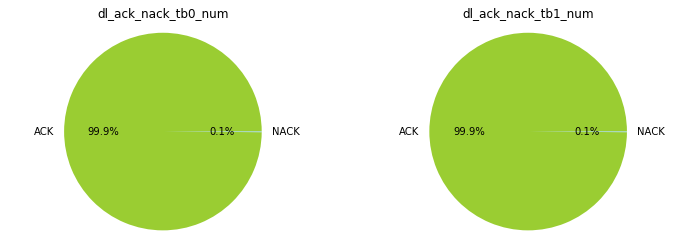

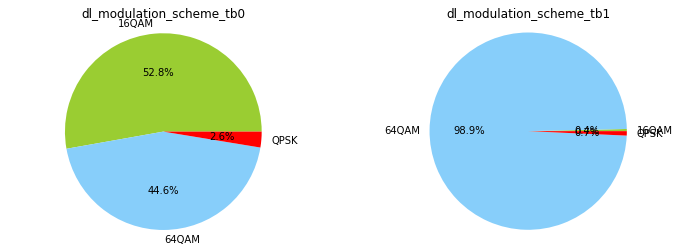

Start to analyze ULSCHRX log...
mean path loss: 10.0


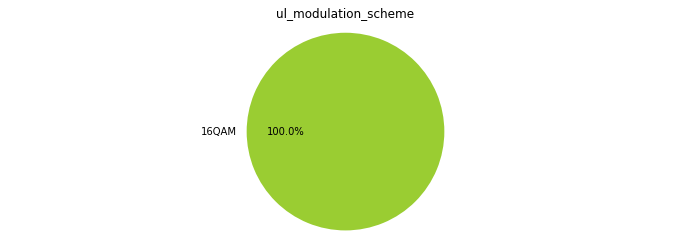

In [7]:
dlschrx_process()
ulschtx_process()

### 处理L1DLSTATS和L1ULSTATS

In [8]:
def l1dlstats_process():
    # 读取Log文件，如果文件不存在返回打印信息       
    l1_dl_stats = glob.glob("./*L1DLSTATS*.csv")      
    if l1_dl_stats:
        file = l1_dl_stats[0]
    else:
        print("no l1dlstats info!")
        return      
    
    print("Start to analyze L1DLSTATS log...")
    df_l1_dl_stats = pd.read_csv(file, low_memory=False, skip_blank_lines=True, nrows=800000,
                                 skiprows=csv_prepare(file), na_values=['-'])
        
    # 整理数据
    df_l1_dl_stats = df_l1_dl_stats.iloc[:-1,:-1]
    df_l1_dl_stats.dropna(subset=["Time","UE ID","RAT","Cell Frequency(MHz)"], axis=0, inplace=True)     
    df_l1_dl_stats['Time'] = [pd.datetime.strptime(d,"%H:%M:%S:%f") for d in df_l1_dl_stats['Time']]
    
    if ('SNR (CW: 1)(dB)') not in df_l1_dl_stats:
        df_l1_dl_stats['SNR (CW: 1)(dB)'] = np.nan
        df_l1_dl_stats['Mean MCS.1'] = np.nan

    # CellID，RAT, Frequency, SNR, BLER, MCS统计信息
    cell_groups = df_l1_dl_stats.groupby("Cell ID")
    for cell_id, cell_group in cell_groups:
        cell_id = cell_group["Cell ID"].values[0]
        cell_RAT = cell_group["RAT"].values[0]
        cell_Freq = cell_group["Cell Frequency(MHz)"].values[0]
        cell_dlsch_bler = cell_group["DL-SCH BLER"].mean()*100        
        cell_snr0 = cell_group["SNR (CW: 0)(dB)"].mean()
        cell_dlsch_mcs0 = cell_group["Mean MCS"].mean()    
        cell_snr1 = cell_group["SNR (CW: 1)(dB)"].mean()        
        cell_dlsch_mcs1 = cell_group["Mean MCS.1"].mean()         
                 
        print("Physical Cell ID:", int(cell_id))
        print("CELL RAT: %s " %cell_RAT)
        print("CELL Frequency: %sMHz" %cell_Freq)
        print("CELL DL-SCH BLER: %.1f" %cell_dlsch_bler+"%")         
        print("CELL DL Mean SNR for CW0: %.1f" %cell_snr0)
        print("CELL DL Mean MCS for CW0: %.1f" %cell_dlsch_mcs0)
        print("CELL DL Mean SNR for CW1: %.1f" %cell_snr1)            
        print("CELL DL Mean MCS for CW1: %.1f" %cell_dlsch_mcs1) 
        
def l1ulstats_process():
    # 读取Log文件，如果文件不存在返回打印信息        
    l1_ul_stats = glob.glob("./*L1ULSTATS*.csv") 
    if l1_ul_stats:
        file = l1_ul_stats[0]
    else:
        print("no l1ulstats info!")
        return

    print("Start to analyze L1ULSTATS log...")
    df_l1_ul_stats = pd.read_csv(file, low_memory=False, skip_blank_lines=True, nrows=800000,
                                 skiprows=csv_prepare(file), na_values=['-'])
        
    # 整理数据 
    df_l1_ul_stats = df_l1_ul_stats.iloc[:-1,:-1]
    df_l1_ul_stats.dropna(subset=["Time","UE ID","RAT","Cell Frequency(MHz)"], axis=0, inplace=True)     
    df_l1_ul_stats['Time'] = [pd.datetime.strptime(d,"%H:%M:%S:%f") for d in df_l1_ul_stats['Time']]

    # CellID，RAT, Frequency, SNR, BLER, MCS统计信息
     
    cell_groups = df_l1_ul_stats.groupby("Cell ID")
    for cell_id, cell_group in cell_groups:
        cell_id = cell_group["Cell ID"].values[0]   
        cell_RAT = cell_group["RAT"].values[0]
        cell_Freq = cell_group["Cell Frequency(MHz)"].values[0]
        cell_ulsch_cqi = cell_group["Mean Wideband CQI"].mean()
        cell_ulsch_bler = cell_group["UL-SCH BLER"].mean()*100
        cell_ulsch_mcs0 = cell_group["Mean MCS"].mean()     
                   
        print("Physical Cell ID:", int(cell_id))
        print("CELL RAT: %s " %cell_RAT)
        print("CELL UL Frequency: %sMHz" %cell_Freq)
        print("CELL UL-SCH BLER: %.1f" %cell_ulsch_bler+"%")         
        print("CELL UL Mean Wideband CQI: %0.1f" %cell_ulsch_cqi)
        print("CELL UL Mean MCS for CW0: %.1f" %cell_ulsch_mcs0)   

In [9]:
l1dlstats_process()
l1ulstats_process()

Start to analyze L1DLSTATS log...
Physical Cell ID: 185
CELL RAT: FDD 
CELL Frequency: 940.0MHz
CELL DL-SCH BLER: 0.1%
CELL DL Mean SNR for CW0: 0.0
CELL DL Mean MCS for CW0: 17.7
CELL DL Mean SNR for CW1: 0.0
CELL DL Mean MCS for CW1: 24.3
no l1ulstats info!
